<a href="https://colab.research.google.com/github/mdrk300902/demo-repo/blob/main/Image_Super_Resolution_Using_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Problem Statement**
##Image Super-Resolution Using ESRGAN
The goal of this project is to upscale low-resolution images to high-resolution, recovering fine details and textures using Enhanced Super-Resolution Generative Adversarial Networks (ESRGAN). We compare the original HR, bicubic downsampled LR, and ESRGAN-upscaled SR results, reporting metrics like PSNR and SSIM to evaluate perceptual and pixel-level quality.

##Structured Project Flow
Below is a clear, cell-wise organization. Each code cell performs a well-defined purpose and is commented accordingly for clarity and reproducibility

##1. Installation
Install all necessary libraries

In [87]:
# Install dependencies
!pip install tensorflow tensorflow_hub pillow matplotlib scikit-image

import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

## 2. Preprocess and standardize input images for ESRGAN compatibility.


In [88]:
# Helper Functions
def preprocess_image(image_path):
    """Loading image from path and preprocessing to make it model ready (Safe shape handling)."""
    img_bytes = tf.io.read_file(image_path)
    if image_path.lower().endswith('.png'):
        hr_image = tf.image.decode_png(img_bytes, channels=3)
    else:
        hr_image = tf.image.decode_jpeg(img_bytes, channels=3)

    hr_image.set_shape([None, None, 3])
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

## 3.Save processed image tensors as JPEG files for easy access and sharing.


In [89]:
def save_image(image, filename):
    """Saves unscaled Tensor Images."""
    if isinstance(image, tf.Tensor):
        image = tf.clip_by_value(image, 0, 255)
        image = tf.cast(image, tf.uint8).numpy()
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image.save(f"{filename}.jpg")
    print(f" Saved as {filename}.jpg")

## 4.Generate low-resolution test images by bicubic downsampling the originals.


In [90]:
def downscale_image(image):
    """Scales down images using bicubic downsampling."""
    if len(image.shape) == 3:
        height = int(image.shape[0])
        width = int(image.shape[1])
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))
    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize((width // 4, height // 4), Image.BICUBIC)  # tuple (W,H)
    )
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

## 5.Visualize and compare original, low-resolution, and ESRGAN-upscaled images with metrics.


In [91]:
def plot_comparison(hr_image, lr_image, sr_image, psnr, ssim_score, title=""):
    """Plots HR, LR, and SR images side by side."""
    plt.rcParams['figure.figsize'] = [18, 6]
    fig, axes = plt.subplots(1, 3)
    fig.suptitle(
        f"{title} | PSNR: {psnr:.2f} dB | SSIM: {ssim_score:.3f}",
        fontsize=14
    )

    axes[0].imshow(tf.cast(tf.squeeze(hr_image), tf.uint8).numpy())
    axes[0].set_title("Original (HR)")
    axes[0].axis("off")

    axes[1].imshow(tf.cast(tf.squeeze(lr_image), tf.uint8).numpy())
    axes[1].set_title("Low Resolution (x4 Bicubic)")
    axes[1].axis("off")

    axes[2].imshow(tf.cast(sr_image, tf.uint8).numpy())
    axes[2].set_title("Super Resolution (ESRGAN)")
    axes[2].axis("off")

    plt.show()

## 6.Process an image through the ESRGAN pipeline, display results, compute metrics, and save outputs.

In [92]:
def run_esrgan(image_path, model, title="Image"):

    print(f" Processing: {title}")

    # Preprocess + Downscale
    hr_image = preprocess_image(image_path)
    lr_image = downscale_image(tf.squeeze(hr_image))

    # Run model
    start = time.time()
    sr_image = model(lr_image)
    sr_image = tf.squeeze(sr_image)
    elapsed = time.time() - start

    # Compute Metrics
    psnr = tf.image.psnr(
        tf.clip_by_value(sr_image, 0, 255),
        tf.clip_by_value(tf.squeeze(hr_image), 0, 255),
        max_val=255
    ).numpy()

    ssim_score = ssim(
        tf.cast(tf.squeeze(hr_image), tf.uint8).numpy(),
        tf.cast(sr_image, tf.uint8).numpy(),
        channel_axis=2
    )

    # Logs
    print(f" Inference Time: {elapsed:.3f} sec")
    print(f" PSNR: {psnr:.2f} dB | SSIM: {ssim_score:.3f}")

    # Plot
    plot_comparison(hr_image, lr_image, sr_image, psnr, ssim_score, title)

    # Save Result
    save_image(sr_image, filename=f"SR_{title.replace(' ', '_')}")
    return psnr, ssim_score


## 7.Download Test Images

In [104]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg

--2025-08-18 14:30:03--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.007s  

2025-08-18 14:30:03 (4.93 MB/s) - ‘original.png’ saved [34146/34146]

--2025-08-18 14:30:03--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c06::84
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting respon

## 8. Load Model Path

In [105]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
print("\n Loading ESRGAN model...")
model = hub.load(SAVED_MODEL_PATH)
print(" Model loaded.")


 Loading ESRGAN model...
 Model loaded.


## 9. Run ESRGAN on images

 Processing: Original PNG Image
 Inference Time: 0.017 sec
 PSNR: 23.48 dB | SSIM: 0.610


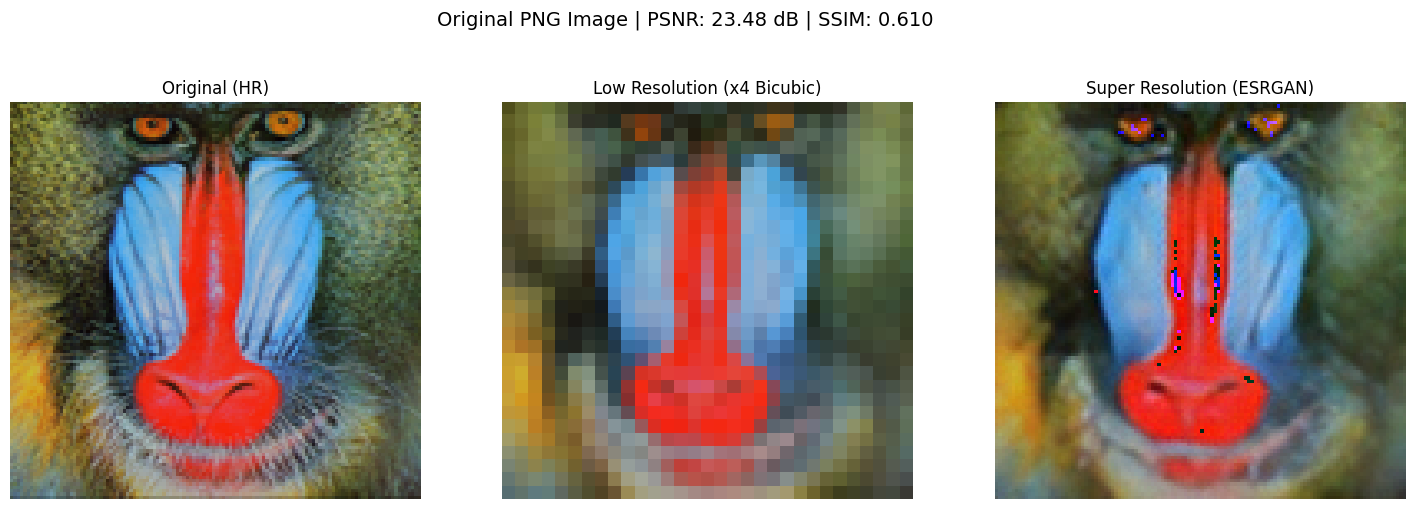

 Saved as SR_Original_PNG_Image.jpg

 Final Results:
Original.png → PSNR: 23.48 dB | SSIM: 0.610
Test.jpg     → PSNR: 27.95 dB | SSIM: 0.751


In [108]:
#Image 1
psnr1, ssim1 = run_esrgan("original.png", model, title="Original PNG Image")


print("\n Final Results:")
print(f"Original.png → PSNR: {psnr1:.2f} dB | SSIM: {ssim1:.3f}")
print(f"Test.jpg     → PSNR: {psnr2:.2f} dB | SSIM: {ssim2:.3f}")

 Processing: Face Test Image
 Inference Time: 1.023 sec
 PSNR: 27.95 dB | SSIM: 0.751


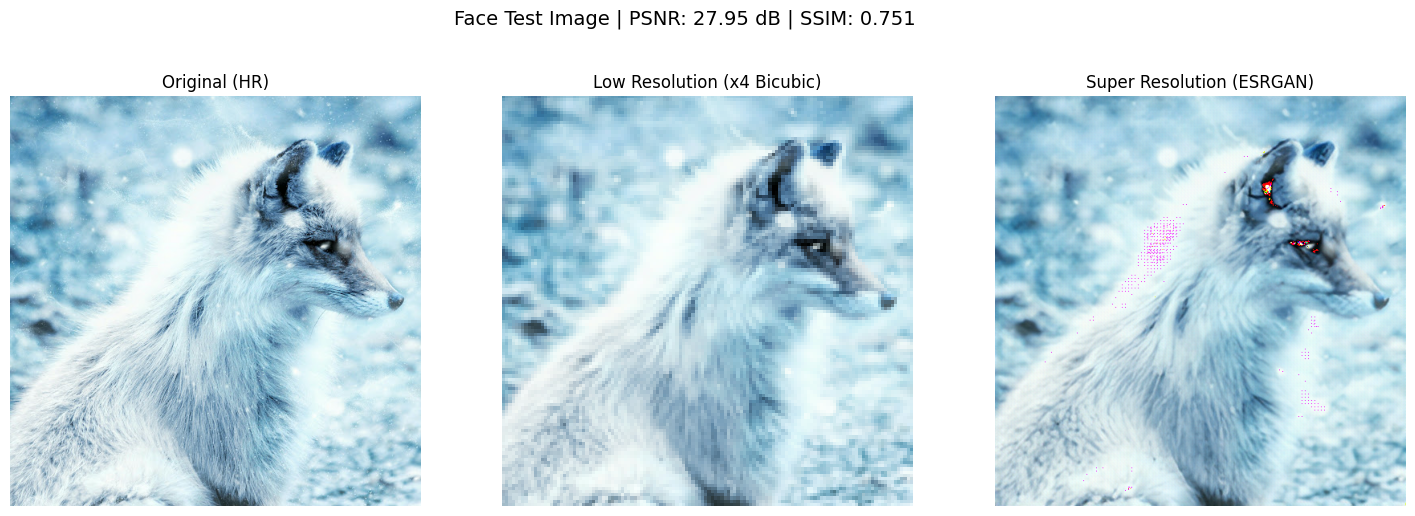

 Saved as SR_Face_Test_Image.jpg

 Final Results:
Original.png → PSNR: 23.48 dB | SSIM: 0.610
Test.jpg     → PSNR: 27.95 dB | SSIM: 0.751


In [109]:
#Image 2
psnr2, ssim2 = run_esrgan("test.jpg", model, title="Face Test Image")

print("\n Final Results:")
print(f"Original.png → PSNR: {psnr1:.2f} dB | SSIM: {ssim1:.3f}")
print(f"Test.jpg     → PSNR: {psnr2:.2f} dB | SSIM: {ssim2:.3f}")

Saving download.jpeg to download (2).jpeg
 Processing: download (2).jpeg
 Inference Time: 0.943 sec
 PSNR: 28.41 dB | SSIM: 0.795


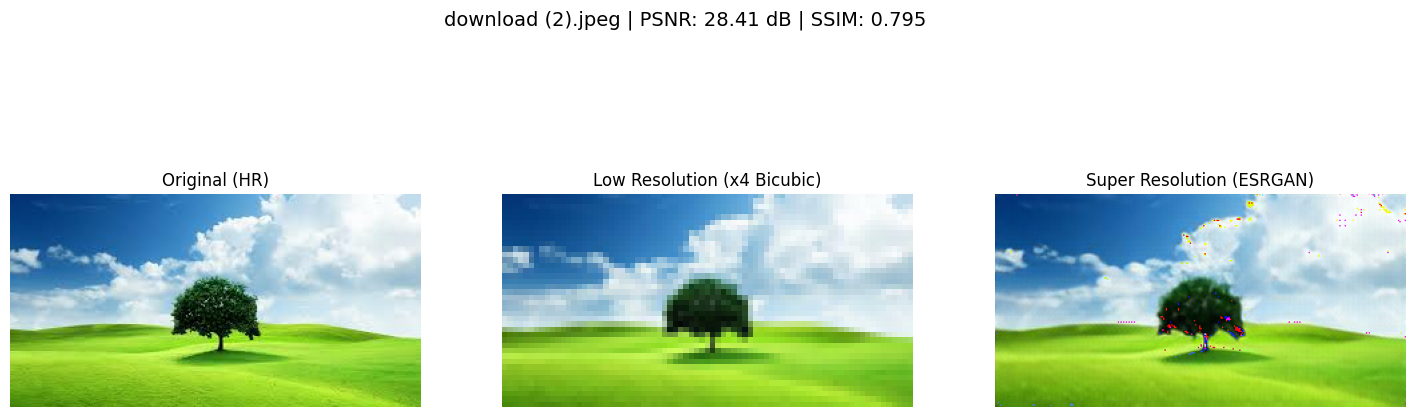

 Saved as SR_download_(2).jpeg.jpg


In [110]:
#Image 3
from google.colab import files
uploaded = files.upload()
for fname in uploaded.keys():
    psnr, ssimval = run_esrgan(fname, model, title=fname)

Saving download (1).jpeg to download (1) (1).jpeg
 Processing: download (1) (1).jpeg
 Inference Time: 1.432 sec
 PSNR: 21.90 dB | SSIM: 0.532


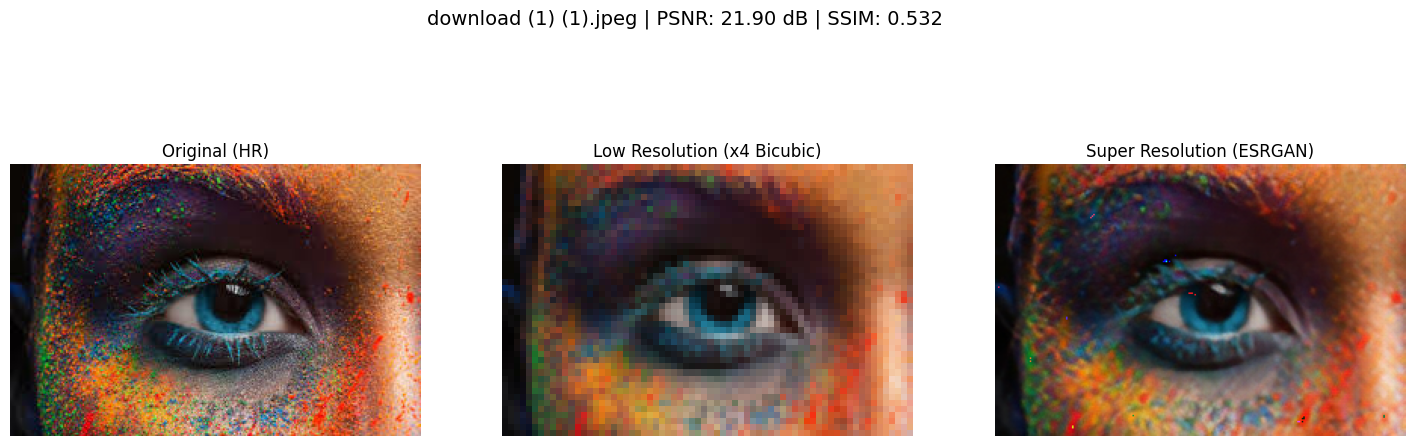

 Saved as SR_download_(1)_(1).jpeg.jpg


In [111]:
#Image 4
from google.colab import files
uploaded = files.upload()
for fname in uploaded.keys():
    psnr, ssimval = run_esrgan(fname, model, title=fname)